In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from polygon import StocksClient  # Ensure correct import based on Polygon API
import logging

In [22]:
API_KEY = "uwQtl3txGt5BLbecq7ZbIu0ZbuitCGjc"

In [23]:

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

2024-09-30 14:43:12,083 - INFO - HTTP Request: GET https://api.polygon.io/v2/aggs/ticker/GLD/range/1/day/2019-01-01/2024-09-01?adjusted=true&sort=asc&limit=500000 "HTTP/1.1 200 OK"
2024-09-30 14:43:12,169 - INFO - Mean: 168.45, Standard Deviation: 23.65


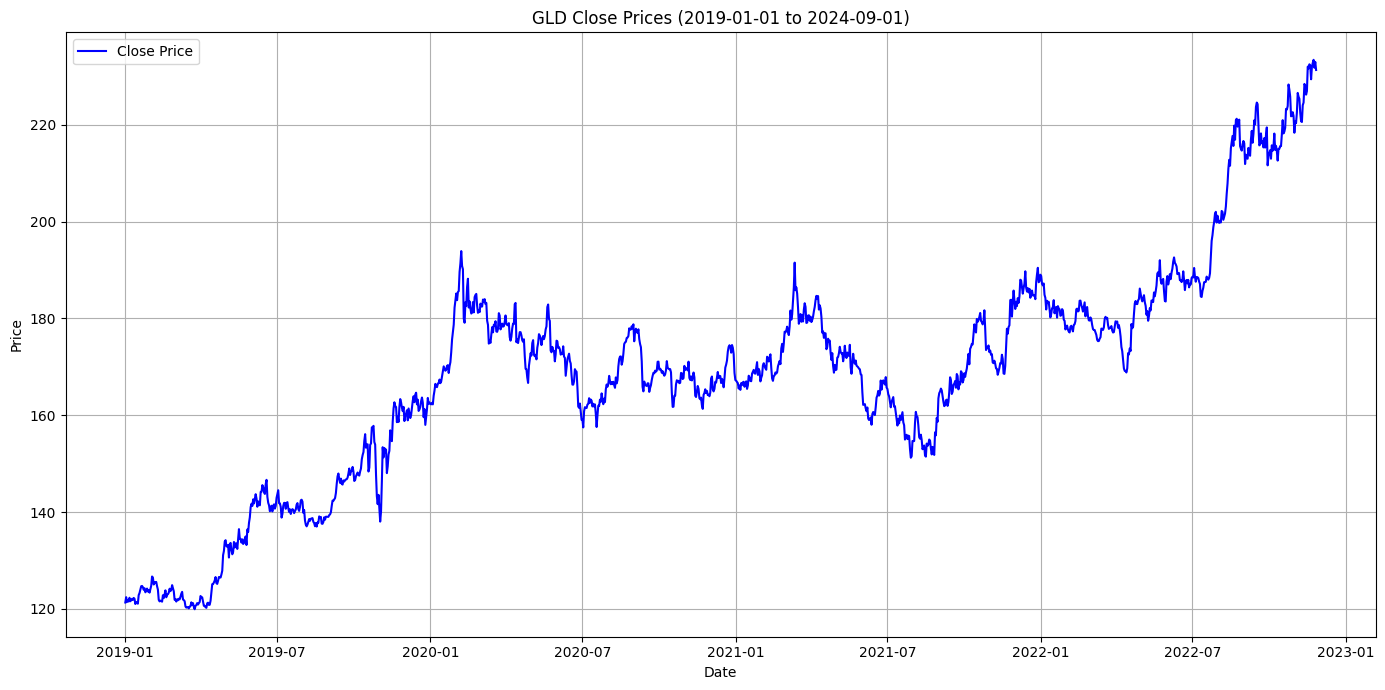

In [25]:
async def get_GLD():
    try:
        # Initialize the asynchronous stock client
        async_stock_client = StocksClient(API_KEY, True)
        
        # Fetch the aggregate bars data for 'GLD'
        response = await async_stock_client.get_aggregate_bars(
            'GLD',
            '2019-01-01',
            '2024-09-01',
            full_range=True
        )        
        # Convert the response to a Pandas DataFrame
        df = pd.DataFrame(response)
     
        df['Date'] = pd.to_datetime(df['t'], unit='ms')        
        
        # Set 'Date' as index
        df.set_index('Date', inplace=True)
        
        # Drop original timestamp column
        df.drop(columns=['t'], inplace=True)
        
        # Assume daily frequency
        start_date = pd.to_datetime('2019-01-01')
        num_rows = len(df)
        df['Date'] = pd.date_range(start=start_date, periods=num_rows, freq='D')
        df.set_index('Date', inplace=True)    

        
        df['c'] = pd.to_numeric(df['c'], errors='coerce')
        
        # Calculate mean and standard deviation of the 'c' (close) prices
        mean = df['c'].mean()
        std = df['c'].std()
        logging.info(f"Mean: {mean:.2f}, Standard Deviation: {std:.2f}")
        
        # Identify outliers: prices more than 3 standard deviations from the mean
        outliers = df[(np.abs(df['c'] - mean) / std) > 3]
        if not outliers.empty:
            logging.info(f"Detected {len(outliers)} outliers.")
        
        # Gets rid of other ticker details
        df = df[['c']]

        # Plot the 'c' (close) prices over time
        plt.figure(figsize=(14, 7))
        plt.plot(df.index, df['c'], label='Close Price', color='blue')
        
        # Highlight outliers if any
        if not outliers.empty:
            plt.scatter(outliers.index, outliers['c'], color='red', label='Outliers')
        
        plt.title('GLD Close Prices (2019-01-01 to 2024-09-01)')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
        # Save the DataFrame to a CSV file
        csv_filename = 'GLD-Prices.csv'
        df.to_csv(csv_filename, index=True)
    
    except Exception as e:
        logging.error(f"An error occurred: {e}")



await get_GLD()
